<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/seed_natimm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

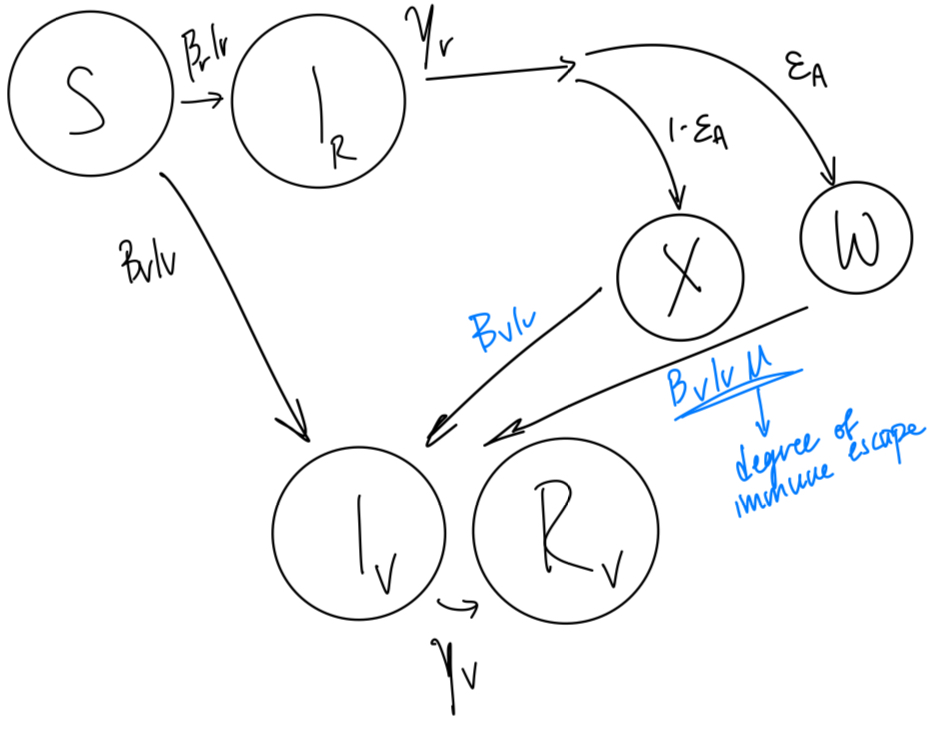

$\frac{\mathrm{d}S}{\mathrm{d}t} = -(\beta_r I_r + \beta_v I_v)S$

$\frac{\mathrm{d}I_r}{\mathrm{d}t} = \beta_r I_r [S+N+(1-\epsilon_L) P] - \gamma_r I_r $

$\frac{\mathrm{d}N}{\mathrm{d}t} = (1-\epsilon_a)\gamma_rI_r - (\beta_v I_v + \beta_r I_r) N $

$\frac{\mathrm{d}P}{\mathrm{d}t} = \epsilon_a\gamma_rI_r - \beta_r I_r(1-\epsilon_L)P - \beta_v I_v (1-(1-\mu)\epsilon_L) P$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \beta_v I_v [S + N + (1-(1-\mu)\epsilon_L)] P - \gamma_v I_v$

$\frac{\mathrm{d}R_v}{\mathrm{d}t} = \gamma_v I_v$

#MUST RUN

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# SIR model equations
def SIR_model_rv(t, y, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
    S, Iw, N, P, Im, Rm, CIw, CIm  = y

    dSdt = -(betaw*Iw+ betam*Im) * S
    dIwdt = betaw * Iw* (S + N + (1-epsilonL)*P)  - gammaw * Iw

    dNdt = (1-epsilona)*gammaw * Iw - (betam*Im+betaw*Iw) *N
    dPdt = epsilona * gammaw * Iw-betaw*Iw*(1-epsilonL)*P - betam*Im*(1-((1-mu)*epsilonL))*P

    dImdt = betam*Im*(S + N +(1-((1-mu)*epsilonL))*P) - gammam * Im
    dRmdt = gammam * Im

    dCIwdt = betaw * Iw* (S + N + (1-epsilonL)*P)
    dCImdt = betam*Im*(S + N +(1-((1-mu)*epsilonL))*P)

    return [dSdt, dIwdt, dNdt, dPdt, dImdt, dRmdt, dCIwdt, dCImdt]


In [3]:
#ALWAYS RUN
CIm0 = 0
CIw0 = 0

In [4]:
def _reach_size(t, y, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
    return (y[2]+y[3]) - recovered_threshold #its all recovered ppl
    _reach_size.terminate = True

#FUNCTION TO FIND TIME OF VARIANT RISING
def find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
  sol_findtv = solve_ivp(SIR_model_rv, [0,t], y0,
                  args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
                  events=_reach_size, t_eval = np.linspace(0, t, t)) #changed dense output to np.linspace


  if len(sol_findtv.t_events[0]) == 0:
      return None   # or np.nan

  # get tv and seed Iv
  tv = np.ravel(np.array(sol_findtv.t_events))[0]

  return tv

def solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
  tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

  if tv == None:
    sol_full = solve_ivp(SIR_model_rv, [0,t], y0,
                    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
                    t_eval = np.linspace(0, t, t))

    y_full = sol_full.y
    t_full = sol_full.t

  else:

    sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
                    t_eval = np.linspace(0, tv, t))

    #last timepoint at tv
    y_tv = sol1.y[:, -1]

    #seed small fraction from Iw into Im
    y_tv[1] -= fraction_seed
    y_tv[4] = fraction_seed

    #second part of solution, after tv
    sol2 = solve_ivp(
        SIR_model_rv,
        [tv, t], # start at tv
        y_tv, # use updated initial condition
        args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
        t_eval = np.linspace(tv, t, t)
    )

    #make into one full soln
    t_full = np.concatenate([sol1.t, sol2.t])
    y_full = np.hstack([sol1.y, sol2.y])

  return([t_full, y_full])

def find_finalCIw(solution_y):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution_y
  return(CIw[-1])

def find_finalCIm(solution_y):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution_y
  return(CIm[-1])

def Iw_wave_or_end(solution_y):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution_y

  if Iw[-1] > 0.0002: #MAYBE CHANGE THIS IF NEEDED DEPENDING ON WHAT GRAPHS SHOW
    return "endemic"

  else:
    return "wave"

def Im_wave_or_end(solution_y):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution_y

  if Im[-1] > 0.0002: #MAYBE CHANGE THIS IF NEEDED DEPENDING ON WHAT GRAPHS SHOW
    return "endemic"

  else:
    return "wave"



In [5]:
#plotting functions
def plot_basic(t_full, y_full, figsize = (10, 6), ax=None, title="SIR sim w variant seeded", ylim_max = 1):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)

    S, Iw, N, P, Im, Rm, CIw, CIm  = y_full

    ax.plot(t_full, S, label='Susceptible')
    ax.plot(t_full, Iw, label='Infected (wildtype)')
    ax.plot(t_full, Im, label='Infected (mutant)')
    ax.plot(t_full, Rm, label='Recovered (mutant)')
    ax.plot(t_full, N, label='Immunity_none')
    ax.plot(t_full, P, label='Immunity_leaky')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Proportion of Population')
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax

def plot_cum(solution, ax=None, title="Cumulative infections", ylim_max = 1):
    if ax is None:
        fig, ax = plt.subplots()

    t = solution.t
    *_, CIw, CIm = solution.y

    ax.plot(t, CIw, label="Cumulative WT")
    ax.plot(t, CIm, label="Cumulative variant")

    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Cumulative incidence")
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax


#Stress-Testing scenarios - 2 strain only

1. Two-strain model, variant exists when recovered > 0.1. Natural immunity confers perfect protection against all variants (mu = 0, epsilonL = 1, epsilonA = 1).

P and Rm are absorbing compartments. Im should decrease to 0 fast due to low immune escape properties

In [6]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.6
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

In [7]:
#do solution up to tv
tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                 args=(mu, betaw, gammaw, betam, gammaw, epsilona, epsilonL),
                 t_eval = np.linspace(0, tv, t))

#last timepoint at tv
y_tv = sol1.y[:, -1]

#seed small fraction from Iw into Im
y_tv[1] -= fraction_seed
y_tv[4] = fraction_seed

#second part of solution, after tv
sol2 = solve_ivp(
    SIR_model_rv,
    [tv, t], # start at tv
    y_tv, # use updated initial condition
    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
    t_eval = np.linspace(tv, t, t)
)

#make into one full soln
t_full = np.concatenate([sol1.t, sol2.t])
y_full = np.hstack([sol1.y, sol2.y])
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full


<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

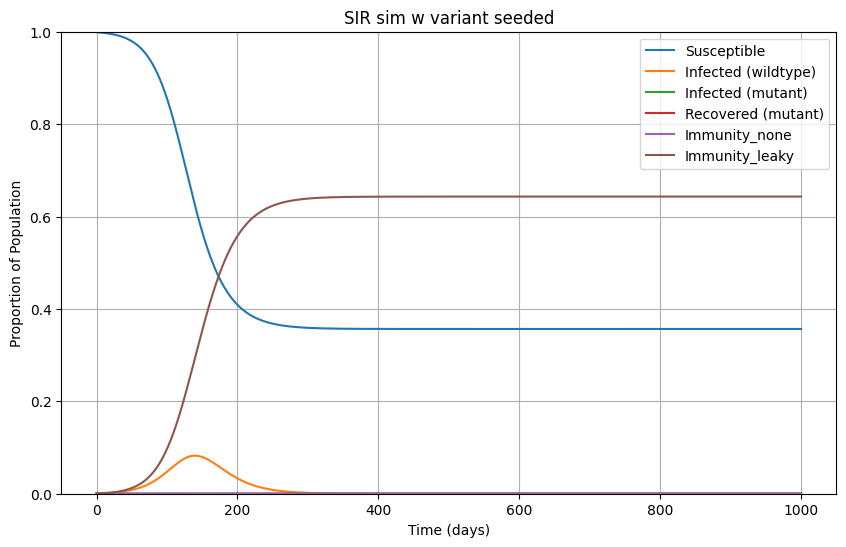

In [8]:
plot_basic(t_full, y_full)

## 7. Two-strain model. Natural immunity confers no protection against any variants, all go to N. Epsilon_A = 0. Immune escape does not matter.

Will see a lot more R_v compared to previous scenario, as the only absorbing compartment. Infected reaches higher final epidemic size and faster as more of the population stays susceptible for longer compared to previous scenario.

In [9]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.6
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0
epsilona = 0
epsilonL = 1
t = 10000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

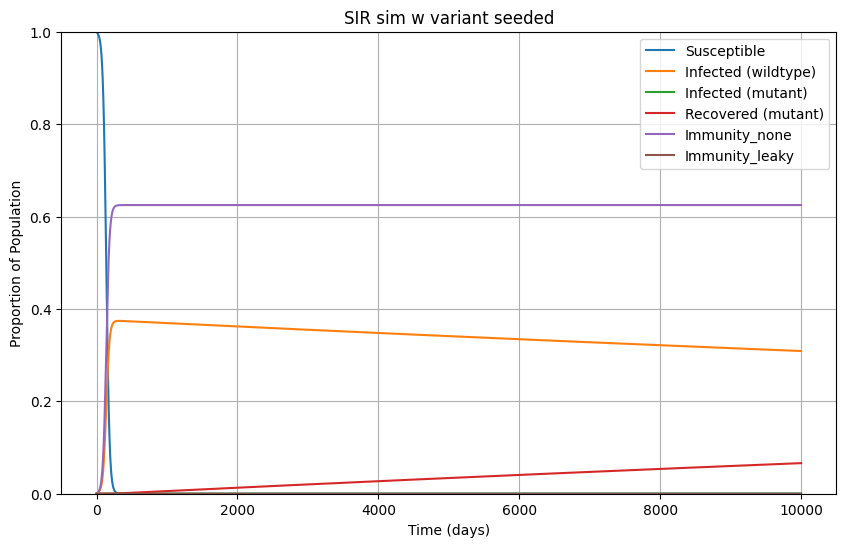

In [10]:
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)



## 7. Two-strain model, all-or-nothing immunity. Epsilon_A = 0.5. Epsilon_L = 1. Immune escape (mu) does matter, as mutant can affect that with perfect protection against wildtype

Im will do better than Iw due to selective advantage that appears once many have recovered? (not true). Only half of recovered pop'n gets selective advantage?  In past model, Im peaked later than Iw, with a lower peak. Seems similar, though less cumulative Im infections, though perhaps more total days infected? see with heatmaps

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

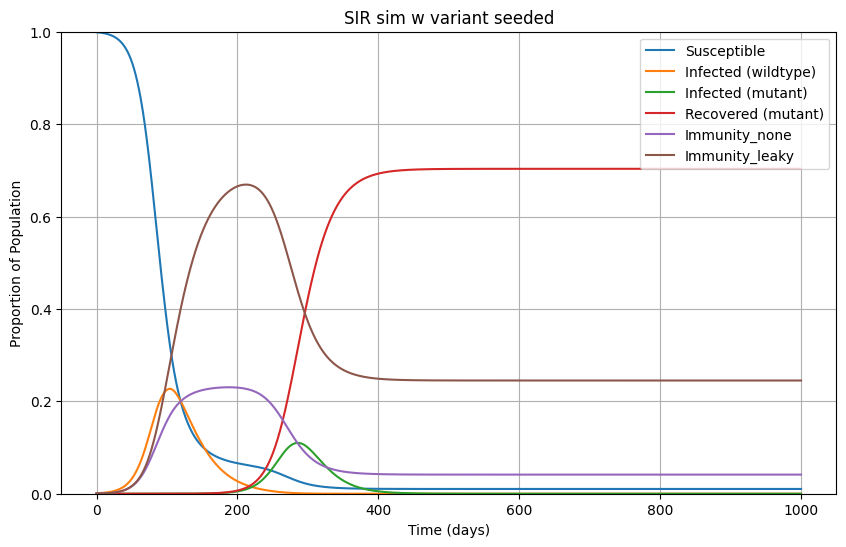

In [11]:
# set parameter values
#betaw = 1.1
Rwnaught = 2
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 0.5
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#solve and plot
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)


## 9. Two-strain model, variant exists at t=0. Leaky immunity (epsilon_A = 0.0, epsilon_L ϵ (0,1))

Greater epidemic size than all-or-nothing model in previous version. All of recovered popn is affected by immune escape, so maybe betetr?

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

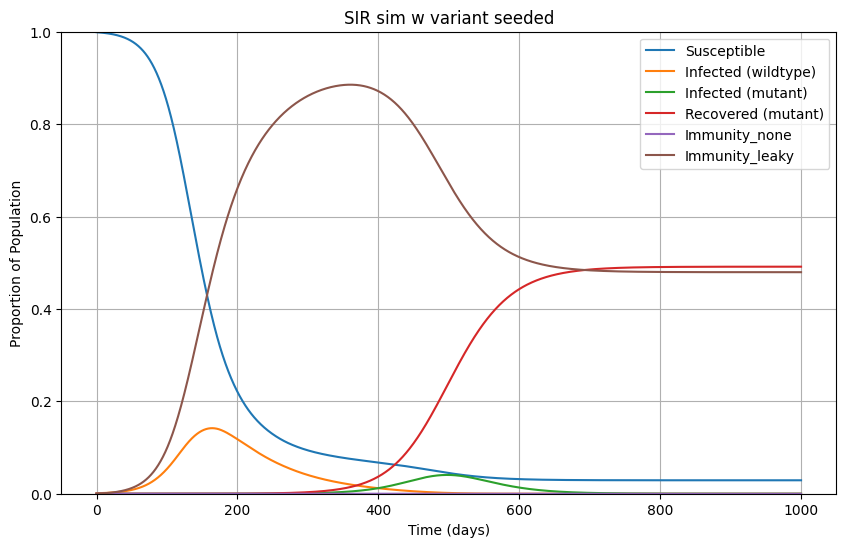

In [12]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#solve and plot
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)


#10. all who recover from wildtype have perfect immunity against wildtype, but. are still susceptible to mutant (epsilons=1, mu >0)

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

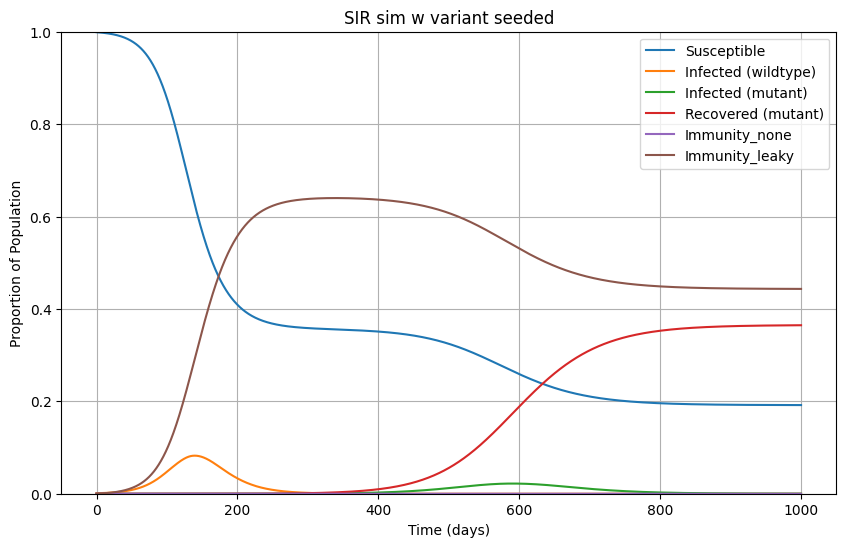

In [13]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#solve and plot
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)


#11. intermediate where some recovered indivs have NO protection, and some indivs have partial protection (and they're still more susceptible to mutant). 0 < epsilons < 1, mu > 0

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

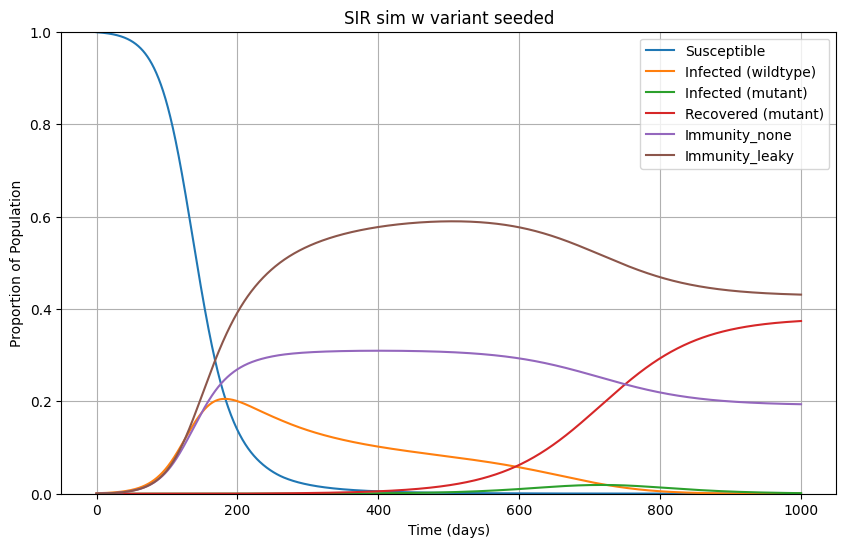

In [14]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.3
epsilona = 0.5
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#solve and plot
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)


#MODULATING MU & PLOTTING RELATIVE FREQUENCIES

##SANITY CHECK

In [15]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.3
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

In [16]:
#function for plotting any two compartment curves (eg. Iw) for many scenarios, with only one (hence mono) specified param (eg. mu) being modulated
def plot_many_mono_anytwo(param, compartment1 = "Iw", compartment2 = "Im", figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with (param val) as as keysn, values being solutions

  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)
  ax2 = fig.add_subplot(122, axisbelow=True)

  for key, solution in kwargs.items():
    S, Iw, N, P, Im, Rm, CIw, CIm =  solution[1] #takes solution out from list
    t = solution[0]

    curves = {
            "S": S,
            "Iw": Iw,
            "N": N,
            "P": P,
            "Im": Im,
            "Rm": Rm,
            "CIm":CIm,
            "CIw":CIw
        }

    label = f"{param} = {key}"
    ax1.plot(t, curves[compartment1], label=label, alpha=0.5)
    ax2.plot(t, curves[compartment2], label=label, alpha=0.5)

  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel((f"{compartment1}"))
  ax1.set_ylim(0,ylim_max)
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)

  ax2.set_xlabel('Time (days)')
  ax2.set_ylabel(f"{compartment2}")
  ax2.set_ylim(0,ylim_max)
  ax2.grid(linewidth=0.5)
  legend = ax2.legend()
  legend.get_frame().set_alpha(0.5)


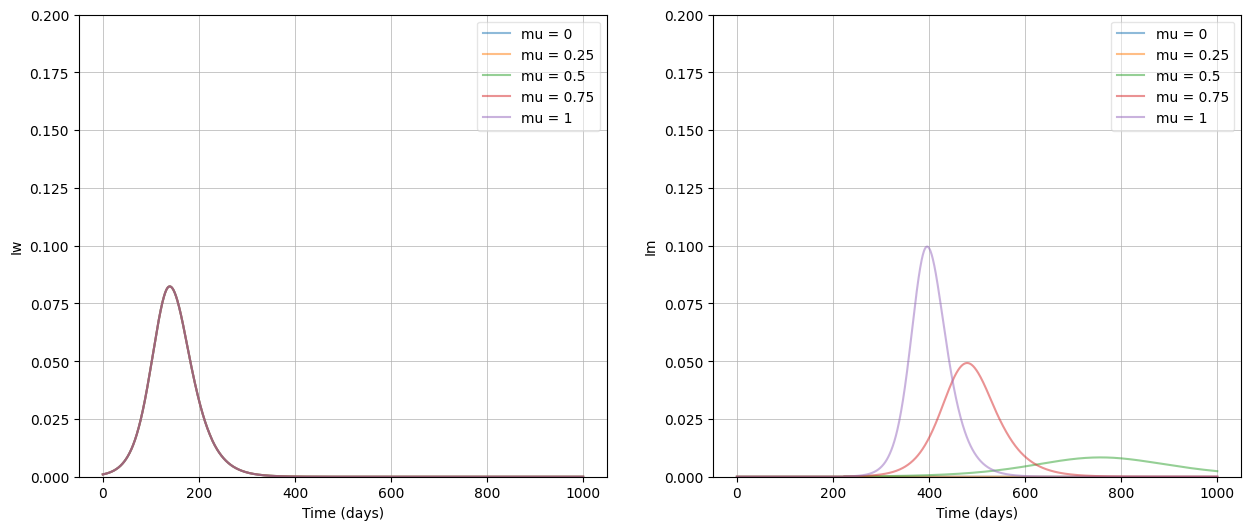

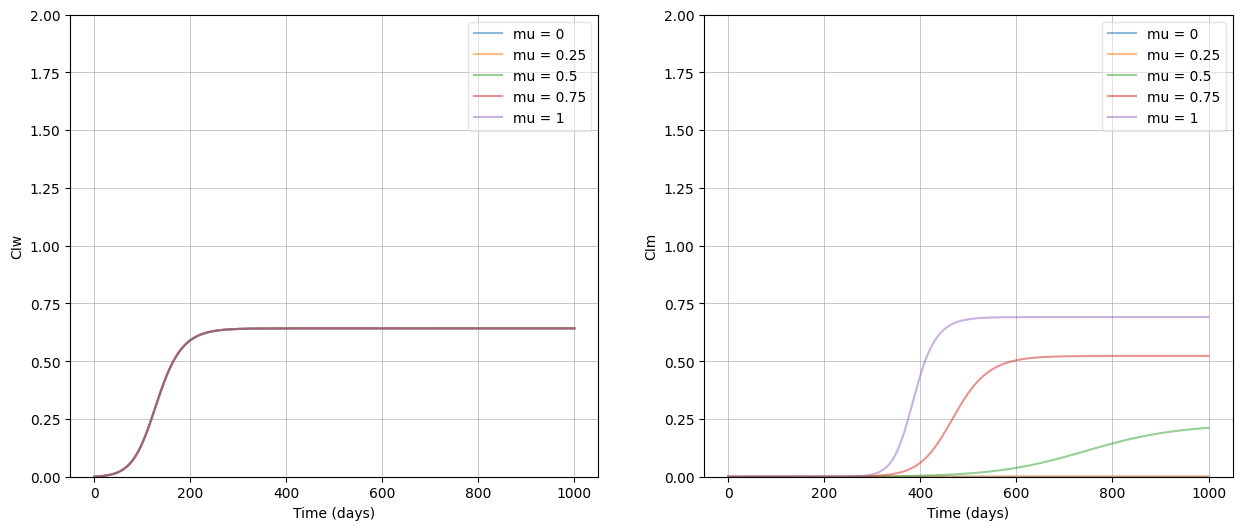

In [17]:
#list of MU
mus = [0, 0.25, 0.5, 0.75, 1] #mu being degre of immune escape, closer to 1 means more escape

kwargs = {}
solutions = []

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(mus)):
  #do solution up to tv
  mu = mus[i]
  tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
  sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                  args=(mu, betaw, gammaw, betaw, gammaw, epsilona, epsilonL),
                  t_eval = np.linspace(0, tv, t))

  #last timepoint at tv
  y_tv = sol1.y[:, -1]

  #seed small fraction from Iw into Im
  y_tv[1] -= fraction_seed
  y_tv[4] = fraction_seed

  #second part of solution, after tv
  sol2 = solve_ivp(
      SIR_model_rv,
      [tv, t], # start at tv
      y_tv, # use updated initial condition
      args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
      t_eval = np.linspace(tv, t, t)
  )

  #make into one full soln
  t_full = np.concatenate([sol1.t, sol2.t])
  y_full = np.hstack([sol1.y, sol2.y])

  solutions.append([t_full, y_full])
  kwargs[str(mus[i])] = solutions[i]

plot_many_mono_anytwo("mu",ylim_max = 0.20,**kwargs)
plot_many_mono_anytwo("mu", compartment1="CIw" , compartment2= "CIm", ylim_max = 2,**kwargs)

# **HEATMAPS**

##goals

- Is there a difference in all-or-nothing vs leaky in proportional reduction of infections? If so, what directions?
- At what levels of immunity, R0s, and mu(?) is the difference more pronounced?
- ^ For two strain, need to consider the possibility of how different the R0s are
- What is the effect of the variant on cumulative infections/total infection days?

In [18]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.3
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.01 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

In [19]:
two_strain_df = pd.DataFrame(columns=['overall_immunity', 'epsilon_a', 'epsilon_L',
                                      'mu', 'R0', 'reduction in inf_days wildtype',
                                      'reduction in inf_days mutant',
                                      'reduction in inf_days ALL',
                                      'total inf_days WT',
                                      'total inf_days MUT',
                                      'total_infected_days_WM',
                                      'one-wave or endemic wild',
                                      'one-wave or endemic mut',])

In [20]:
epsilona_vals = np.linspace(0.05, 1, 20)
immunity_vals = np.linspace(0.05, 1, 20)
Rnaughts = [1, 1.5, 2, 2.5, 8]
mus = [0, 0.35, 0.7, 1]


In [21]:
for mu in mus:
  for Rnaught in Rnaughts:
    t_full, y_full = solve_seeded(t, mu, Rnaught*gammaw, gammaw, Rnaught*gammam, gammam, 0, 0)


    no_imm_totaldays_W = find_finalCIw(y_full)*(1/gammaw)
    no_imm_totaldays_M =  find_finalCIm(y_full)*(1/gammam)
    no_imm_totaldays_ALL = no_imm_totaldays_W+no_imm_totaldays_M

    for eps_A in epsilona_vals:
      for overall_imm in immunity_vals:
        eps_L = (overall_imm.round(3))/(eps_A.round(3))

        #not all epsilons are valid
        if eps_L > 1:
          continue

        t_full, y_full = solve_seeded(t, mu, Rnaught*gammaw, gammaw, Rnaught*gammam, gammam, eps_A, eps_L)

        total_infected_days_W = find_finalCIw(y_full)*(1/gammaw)
        total_infected_days_M = find_finalCIm(y_full)*(1/gammam)
        total_infected_days_WM = total_infected_days_W + total_infected_days_M


        totalred_days_W = (no_imm_totaldays_W - total_infected_days_W)/no_imm_totaldays_W
        totalred_days_M = (no_imm_totaldays_M - total_infected_days_M)/no_imm_totaldays_M

        total_reduction_days = (no_imm_totaldays_ALL - total_infected_days_WM)/no_imm_totaldays_ALL

        #add to df
        two_strain_df.loc[len(two_strain_df)] = [overall_imm.round(3),
                                      eps_A.round(3),
                                      eps_L.round(3),
                                      mu,
                                      Rnaught,
                                      totalred_days_W,
                                      totalred_days_M,
                                      total_reduction_days,
                                      total_infected_days_W,
                                      total_infected_days_M,
                                      total_infected_days_WM,
                                      Iw_wave_or_end(y_full),
                                      Im_wave_or_end(y_full),
                                      ]



In [22]:
two_strain_df

,overall_immunity,epsilon_a,epsilon_L,mu,R0,reduction in inf_days wildtype,reduction in inf_days mutant,reduction in inf_days ALL,total inf_days WT,total inf_days MUT,total_infected_days_WM,one-wave or endemic wild,one-wave or endemic mut
0,0.05,0.05,1.000,0.0,1.0,0.034568,0.038716,0.034923,0.809312,0.075361,0.884672,endemic,wave
1,0.05,0.10,0.500,0.0,1.0,0.034290,0.038386,0.034640,0.809544,0.075387,0.884931,endemic,wave
2,0.10,0.10,1.000,0.0,1.0,0.066414,0.074366,0.067094,0.782615,0.072566,0.855181,endemic,wave
3,0.05,0.15,0.333,0.0,1.0,0.034198,0.038277,0.034547,0.809621,0.075395,0.885017,endemic,wave
4,0.10,0.15,0.667,0.0,1.0,0.066078,0.073967,0.066753,0.782897,0.072597,0.855494,endemic,wave
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0.80,1.00,0.800,1.0,8.0,0.968531,-10.624039,0.952242,26.176969,13.605477,39.782446,wave,wave
4196,0.85,1.00,0.850,1.0,8.0,0.973415,-10.661183,0.957067,22.114378,13.648952,35.763330,wave,wave
4197,0.90,1.00,0.900,1.0,8.0,0.977413,-10.701496,0.961003,18.788484,13.696137,32.484621,wave,wave
4198,0.95,1.00,0.950,1.0,8.0,0.980647,-10.742741,0.964174,16.098825,13.744413,29.843238,wave,wave


In [23]:
#heatmaps for total infected days
heatmaps_bymu = {}


for j, mu in enumerate(mus):
  heatmaps_byr0 = {}
  filtered_df_mu = two_strain_df[two_strain_df["mu"] == mu].copy()

  for i, r0 in enumerate(Rnaughts):
      filtered_df_R0 = filtered_df_mu[filtered_df_mu["R0"] == r0].copy()

      # avoid SettingWithCopyWarning
      filtered_df_R0.loc[:, "overall_immunity"] = filtered_df_R0["overall_immunity"].round(3)
      filtered_df_R0.loc[:, "epsilon_a"] = filtered_df_R0["epsilon_a"].round(3)

      heatmaps_byr0[i] = filtered_df_R0.pivot(index="overall_immunity", columns="epsilon_a",
                                            values="total_infected_days_WM")
  heatmaps_bymu[j] = heatmaps_byr0



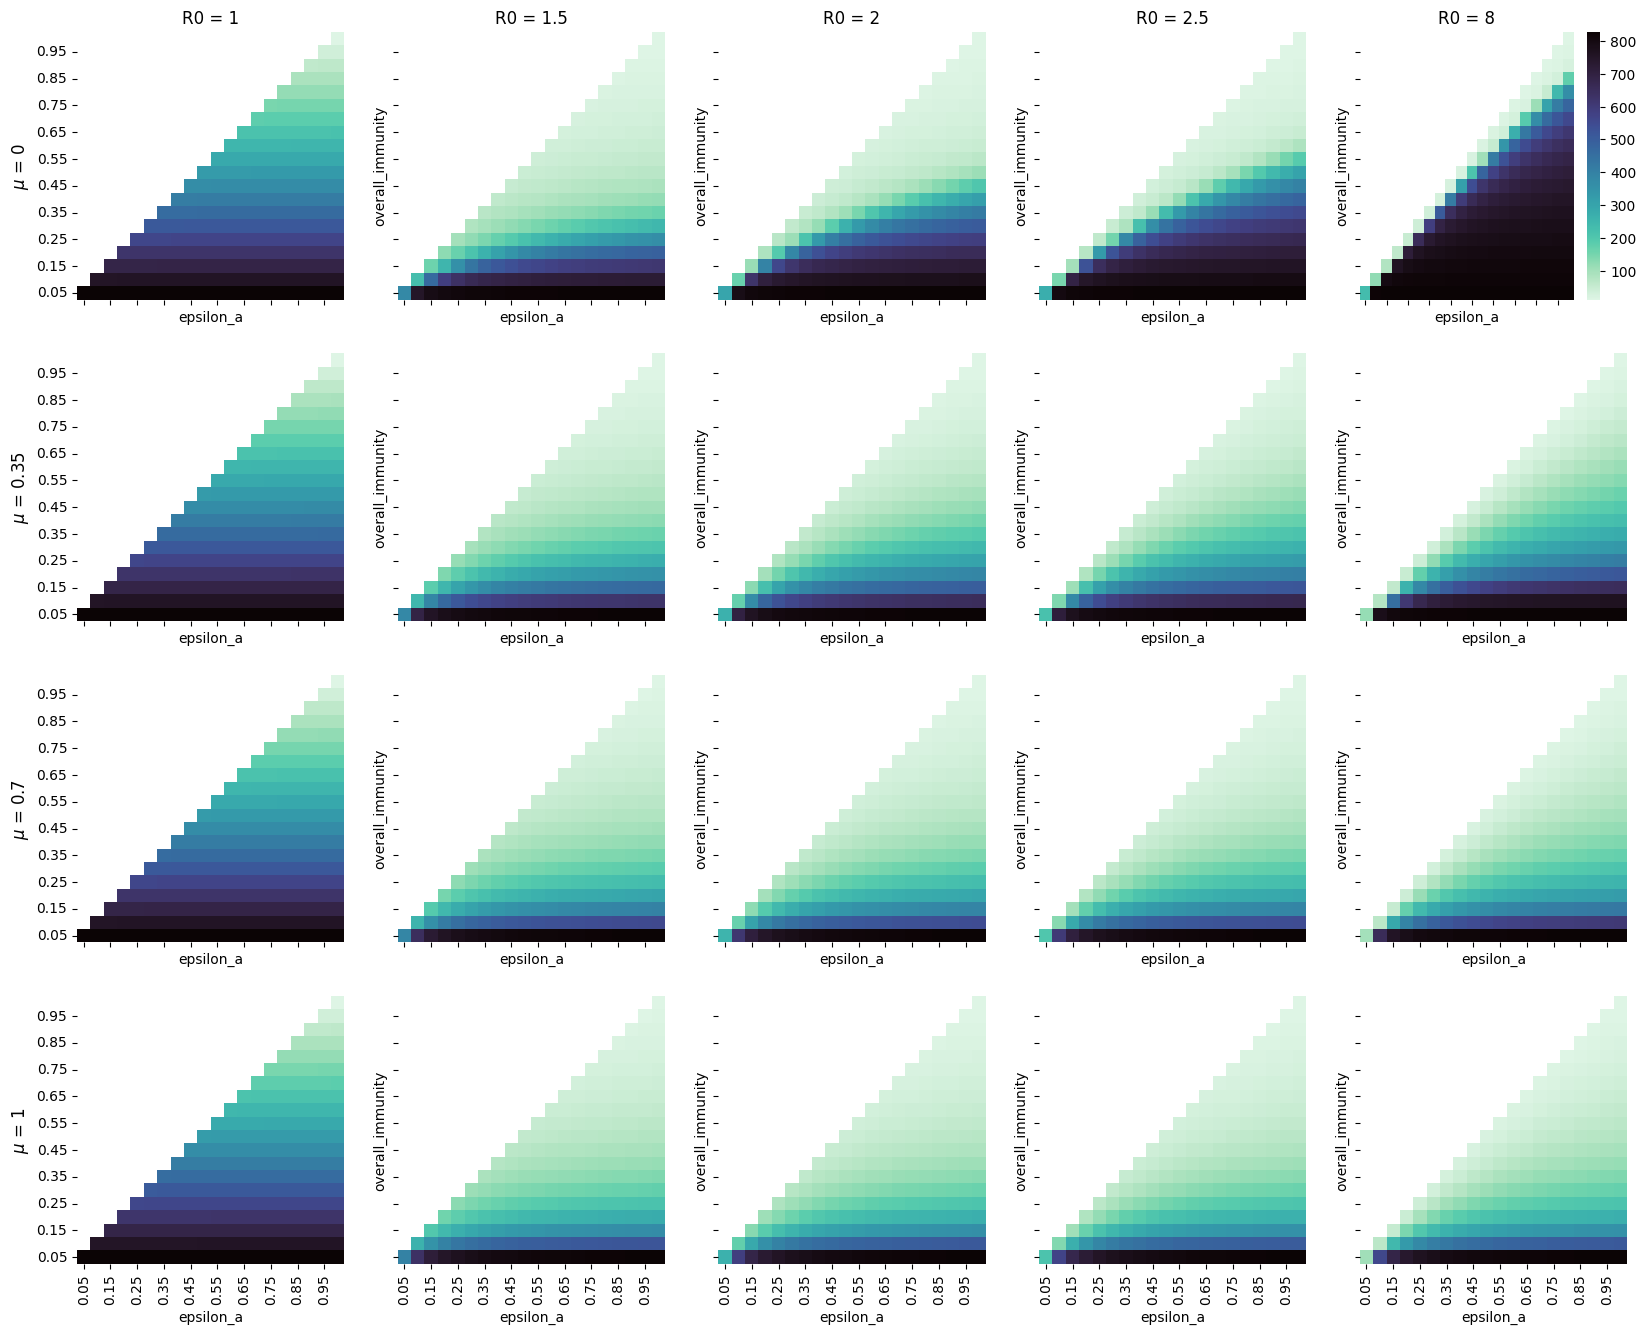

In [24]:
fig, axes = plt.subplots(
    nrows=len(mus),
    ncols=len(Rnaughts),
    figsize=(4 * len(Rnaughts), 4 * len(mus)),
    sharex=True,
    sharey=True
)

for j, mu in enumerate(mus):
    filtered_df_mu = two_strain_df[two_strain_df["mu"] == mu].copy()

    for i, r0 in enumerate(Rnaughts):
        filtered_df_R0 = filtered_df_mu[filtered_df_mu["R0"] == r0].copy()

        filtered_df_R0.loc[:, "overall_immunity"] = filtered_df_R0["overall_immunity"].round(3)
        filtered_df_R0.loc[:, "epsilon_a"] = filtered_df_R0["epsilon_a"].round(3)

        df = filtered_df_R0.pivot(
            index="overall_immunity",
            columns="epsilon_a",
            values="total_infected_days_WM"
        )

        ax = axes[j, i]
        sns.heatmap(df, cmap="mako_r", ax=ax, cbar=(j == 0 and i == len(Rnaughts) - 1))

        # column titles (R0)
        if j == 0:
            ax.set_title(f"R0 = {r0}", fontsize=12)

        # row labels (mu)
        if i == 0:
            ax.set_ylabel(f"$\\mu$ = {mu}", fontsize=12)

        ax.invert_yaxis()


i wonder if this would be the opposite if we could see partial protection and full protection

eg. what is the reason that all or nothing results in less total infected days in all scenarios? this difference is more pronounced as R0 gets bigger, but less pronounced as mu gets bigger (mostly because there's less infections overall)
- more heterogeneity, less total infections, is that due to a decrease in W primarily? like W does so much worse? is AoN still better for WT strain but maybe total infections is worse for the mutant? > LITERALLY CAN CHECK THIS EASY LOL

when 2 strains compete for the same resource, do they overall do worse than if there is only one strain?

need to do heatmaps comparing diff between variant and no variant...

need to code smth that makes solve-seeder and find_tv less likely to be broken

potentially do a version w partial and full isntead of nothing and partial

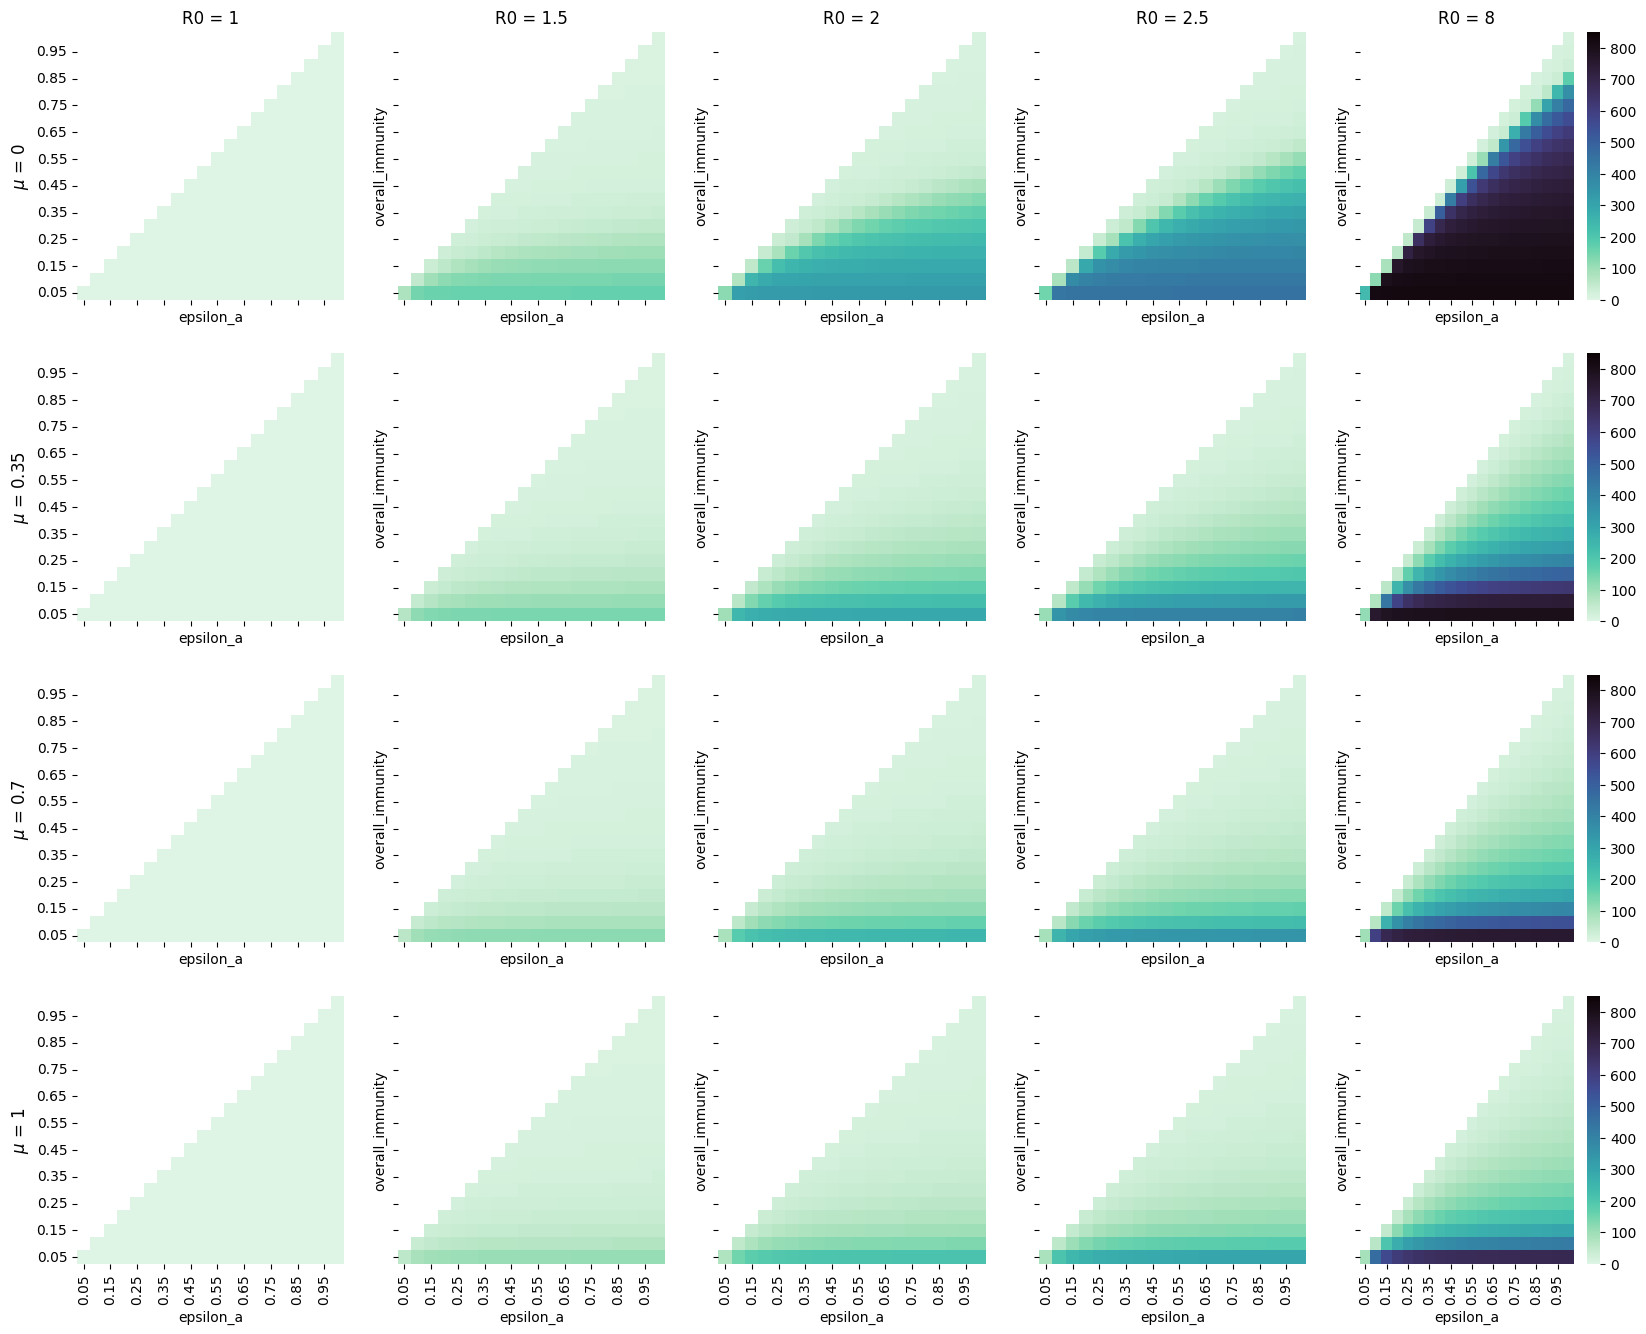

In [25]:
fig, axes = plt.subplots(
    nrows=len(mus),
    ncols=len(Rnaughts),
    figsize=(4 * len(Rnaughts), 4 * len(mus)),
    sharex=True,
    sharey=True
)

for j, mu in enumerate(mus):
    filtered_df_mu = two_strain_df[two_strain_df["mu"] == mu].copy()

    for i, r0 in enumerate(Rnaughts):
        filtered_df_R0 = filtered_df_mu[filtered_df_mu["R0"] == r0].copy()

        filtered_df_R0.loc[:, "overall_immunity"] = filtered_df_R0["overall_immunity"].round(3)
        filtered_df_R0.loc[:, "epsilon_a"] = filtered_df_R0["epsilon_a"].round(3)

        df = filtered_df_R0.pivot(
            index="overall_immunity",
            columns="epsilon_a",
            values="total inf_days WT"
        )

        ax = axes[j, i]
        sns.heatmap(df, cmap="mako_r", ax=ax, vmin = 0, vmax = 850, cbar=(i == len(Rnaughts) - 1))

        # column titles (R0)
        if j == 0:
            ax.set_title(f"R0 = {r0}", fontsize=12)

        # row labels (mu)
        if i == 0:
            ax.set_ylabel(f"$\\mu$ = {mu}", fontsize=12)

        ax.invert_yaxis()


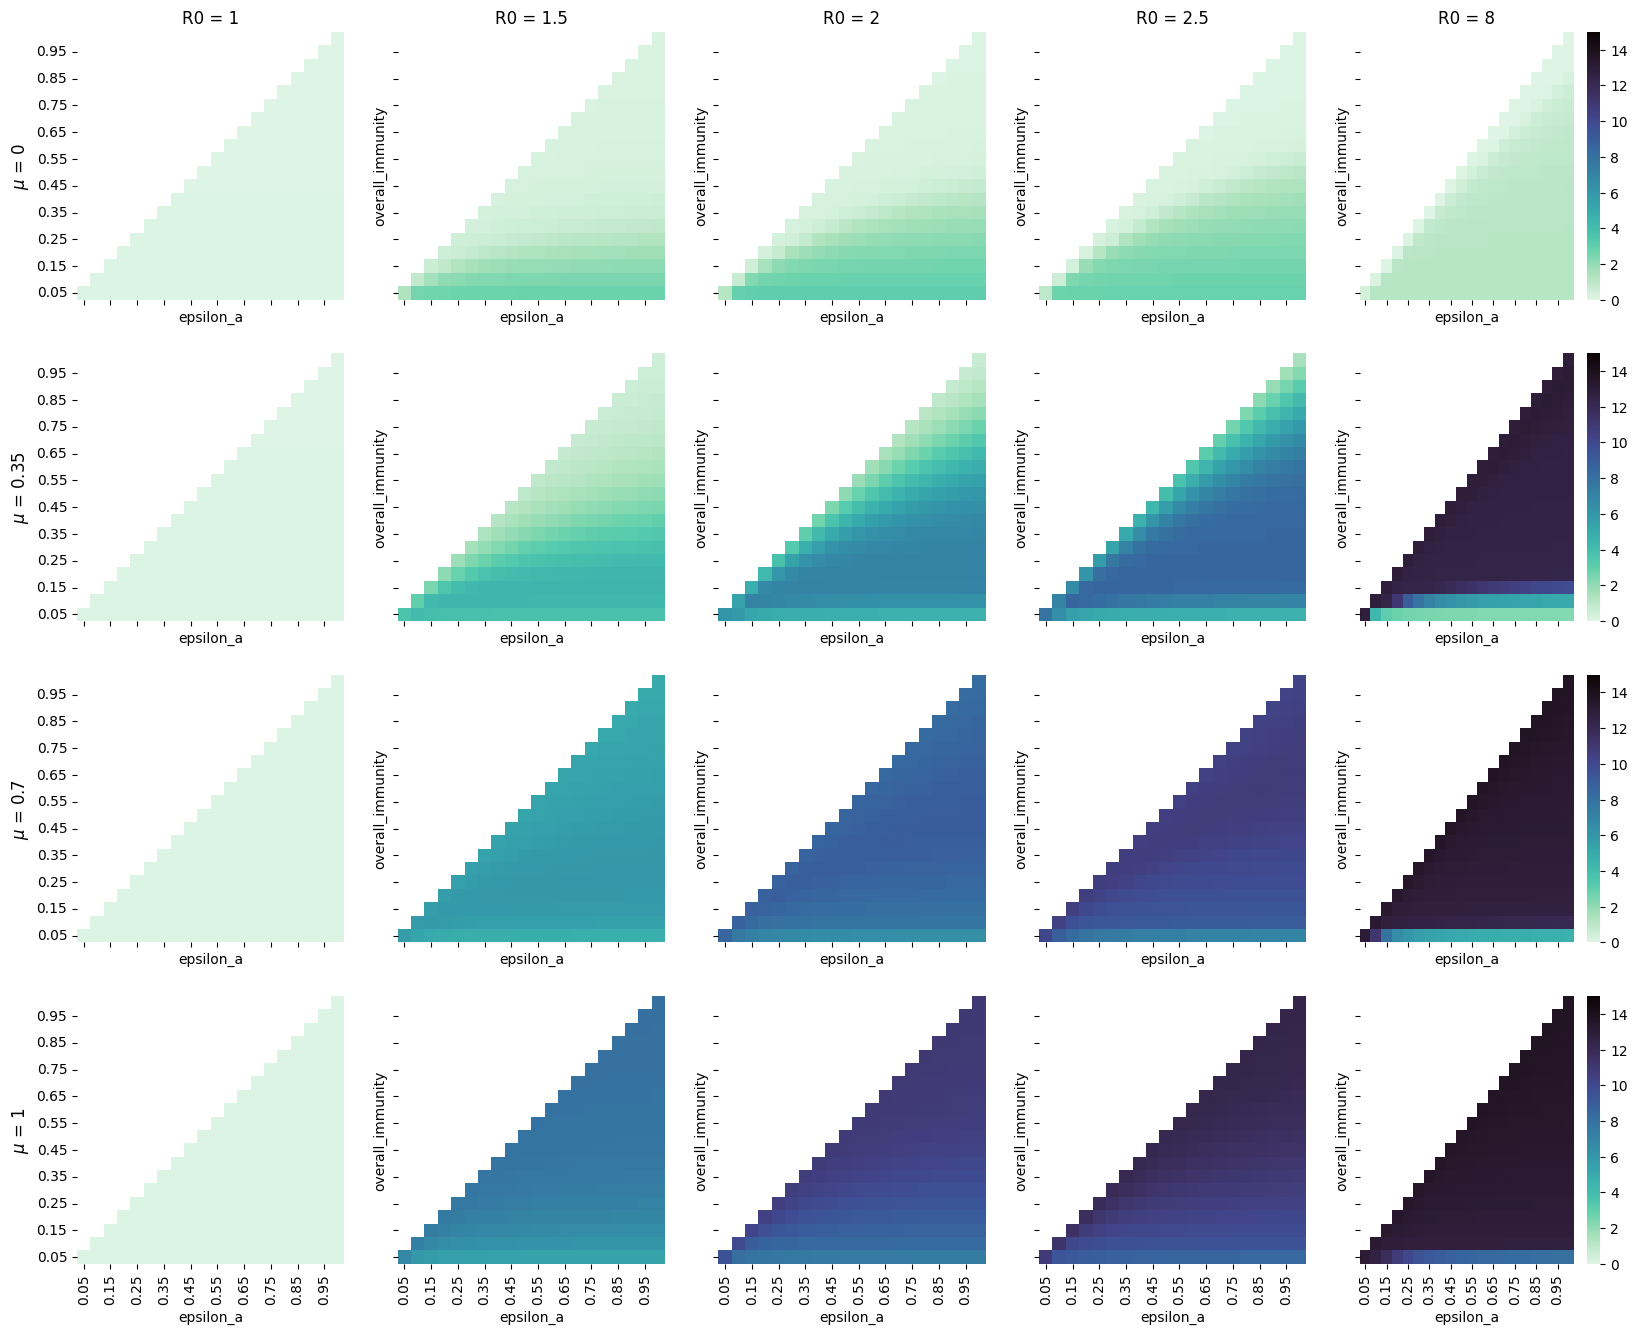

In [26]:
fig, axes = plt.subplots(
    nrows=len(mus),
    ncols=len(Rnaughts),
    figsize=(4 * len(Rnaughts), 4 * len(mus)),
    sharex=True,
    sharey=True
)

for j, mu in enumerate(mus):
    filtered_df_mu = two_strain_df[two_strain_df["mu"] == mu].copy()

    for i, r0 in enumerate(Rnaughts):
        filtered_df_R0 = filtered_df_mu[filtered_df_mu["R0"] == r0].copy()

        filtered_df_R0.loc[:, "overall_immunity"] = filtered_df_R0["overall_immunity"].round(3)
        filtered_df_R0.loc[:, "epsilon_a"] = filtered_df_R0["epsilon_a"].round(3)

        df = filtered_df_R0.pivot(
            index="overall_immunity",
            columns="epsilon_a",
            values="total inf_days MUT"
        )

        ax = axes[j, i]
        sns.heatmap(df, cmap="mako_r", ax=ax, vmin = 0, vmax = 15, cbar=(i == len(Rnaughts) - 1))

        # column titles (R0)
        if j == 0:
            ax.set_title(f"R0 = {r0}", fontsize=12)

        # row labels (mu)
        if i == 0:
            ax.set_ylabel(f"$\\mu$ = {mu}", fontsize=12)

        ax.invert_yaxis()
#smth VERY WEIRDDDD IS HAPPENINGGGGG

In [27]:
two_strain_df[two_strain_df['one-wave or endemic mut'] == 'endemic']

,overall_immunity,epsilon_a,epsilon_L,mu,R0,reduction in inf_days wildtype,reduction in inf_days mutant,reduction in inf_days ALL,total inf_days WT,total inf_days MUT,total_infected_days_WM,one-wave or endemic wild,one-wave or endemic mut
211,0.05,0.10,0.500,0.0,1.5,0.178585,0.178008,0.178576,148.562587,2.523072,151.085659,endemic,endemic
213,0.05,0.15,0.333,0.0,1.5,0.137013,0.136350,0.137002,156.081350,2.650942,158.732292,endemic,endemic
214,0.10,0.15,0.667,0.0,1.5,0.476745,0.476298,0.476737,94.636871,1.607483,96.244354,endemic,endemic
216,0.05,0.20,0.250,0.0,1.5,0.122668,0.121974,0.122656,158.675944,2.695067,161.371011,endemic,endemic
217,0.10,0.20,0.500,0.0,1.5,0.350998,0.350165,0.350984,117.379674,1.994645,119.374319,endemic,endemic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4126,0.05,0.85,0.059,1.0,8.0,0.179524,-5.923065,0.170949,682.496877,8.103173,690.600049,endemic,endemic
4143,0.05,0.90,0.056,1.0,8.0,0.178403,-5.887824,0.169879,683.429554,8.061925,691.491479,endemic,endemic
4161,0.05,0.95,0.053,1.0,8.0,0.177408,-5.856467,0.168930,684.256976,8.025222,692.282199,endemic,endemic
4180,0.05,1.00,0.050,1.0,8.0,0.176522,-5.828446,0.168084,684.993820,7.992425,692.986246,endemic,endemic


In [28]:
two_strain_df[two_strain_df["one-wave or endemic wild"]=='endemic']

,overall_immunity,epsilon_a,epsilon_L,mu,R0,reduction in inf_days wildtype,reduction in inf_days mutant,reduction in inf_days ALL,total inf_days WT,total inf_days MUT,total_infected_days_WM,one-wave or endemic wild,one-wave or endemic mut
0,0.05,0.05,1.000,0.0,1.0,0.034568,0.038716,0.034923,0.809312,0.075361,0.884672,endemic,wave
1,0.05,0.10,0.500,0.0,1.0,0.034290,0.038386,0.034640,0.809544,0.075387,0.884931,endemic,wave
2,0.10,0.10,1.000,0.0,1.0,0.066414,0.074366,0.067094,0.782615,0.072566,0.855181,endemic,wave
3,0.05,0.15,0.333,0.0,1.0,0.034198,0.038277,0.034547,0.809621,0.075395,0.885017,endemic,wave
4,0.10,0.15,0.667,0.0,1.0,0.066078,0.073967,0.066753,0.782897,0.072597,0.855494,endemic,wave
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,0.05,0.80,0.062,1.0,8.0,0.180797,-5.962942,0.172164,681.438026,8.149848,689.587874,endemic,endemic
4126,0.05,0.85,0.059,1.0,8.0,0.179524,-5.923065,0.170949,682.496877,8.103173,690.600049,endemic,endemic
4143,0.05,0.90,0.056,1.0,8.0,0.178403,-5.887824,0.169879,683.429554,8.061925,691.491479,endemic,endemic
4161,0.05,0.95,0.053,1.0,8.0,0.177408,-5.856467,0.168930,684.256976,8.025222,692.282199,endemic,endemic


In [29]:
two_strain_df[two_strain_df["total inf_days MUT"]>1]

,overall_immunity,epsilon_a,epsilon_L,mu,R0,reduction in inf_days wildtype,reduction in inf_days mutant,reduction in inf_days ALL,total inf_days WT,total inf_days MUT,total_infected_days_WM,one-wave or endemic wild,one-wave or endemic mut
210,0.05,0.05,1.000,0.0,1.5,0.572603,0.572861,0.572607,77.299855,1.311087,78.610942,endemic,wave
211,0.05,0.10,0.500,0.0,1.5,0.178585,0.178008,0.178576,148.562587,2.523072,151.085659,endemic,endemic
213,0.05,0.15,0.333,0.0,1.5,0.137013,0.136350,0.137002,156.081350,2.650942,158.732292,endemic,endemic
214,0.10,0.15,0.667,0.0,1.5,0.476745,0.476298,0.476737,94.636871,1.607483,96.244354,endemic,endemic
216,0.05,0.20,0.250,0.0,1.5,0.122668,0.121974,0.122656,158.675944,2.695067,161.371011,endemic,endemic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0.80,1.00,0.800,1.0,8.0,0.968531,-10.624039,0.952242,26.176969,13.605477,39.782446,wave,wave
4196,0.85,1.00,0.850,1.0,8.0,0.973415,-10.661183,0.957067,22.114378,13.648952,35.763330,wave,wave
4197,0.90,1.00,0.900,1.0,8.0,0.977413,-10.701496,0.961003,18.788484,13.696137,32.484621,wave,wave
4198,0.95,1.00,0.950,1.0,8.0,0.980647,-10.742741,0.964174,16.098825,13.744413,29.843238,wave,wave


In [30]:
vmin = two_strain_df["total inf_days MUT"].min()
vmax = two_strain_df["total inf_days MUT"].max()

In [31]:
vmax

13.790734101868486

In [32]:
two_strain_df["total inf_days WT"].max()

825.5016249368794

In [33]:
# set parameter values
#betaw = 1.1
Rwnaught = 21.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.5
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0
epsilona = 0.01
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#solve and plot
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [44]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.5
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0
epsilona = 0.01
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

In [40]:
tv == None

True

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

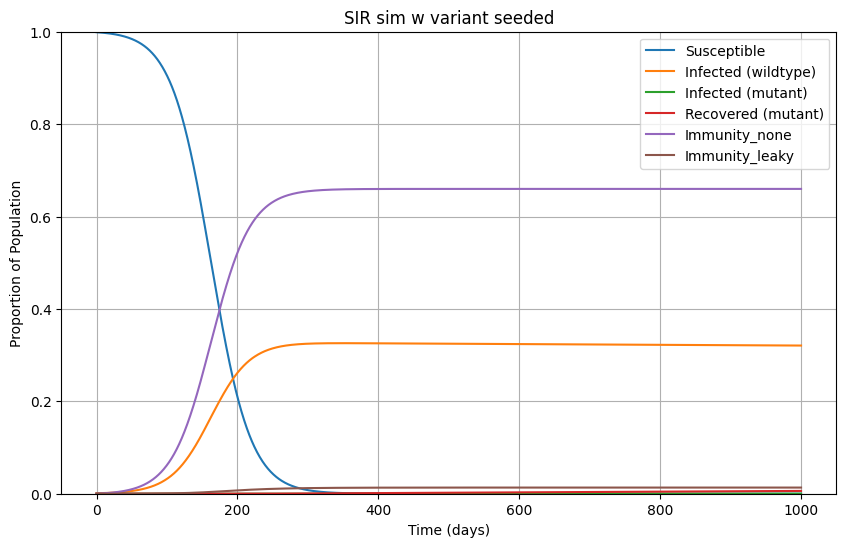

In [45]:
#solve and plot
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)

In [46]:
Im[-1]

np.float64(0.0001085628709756646)

CHECKING IF TV DOES OT EXIST IF IT BREAKS

In [47]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.5
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0
epsilona = 0.01
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.9 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

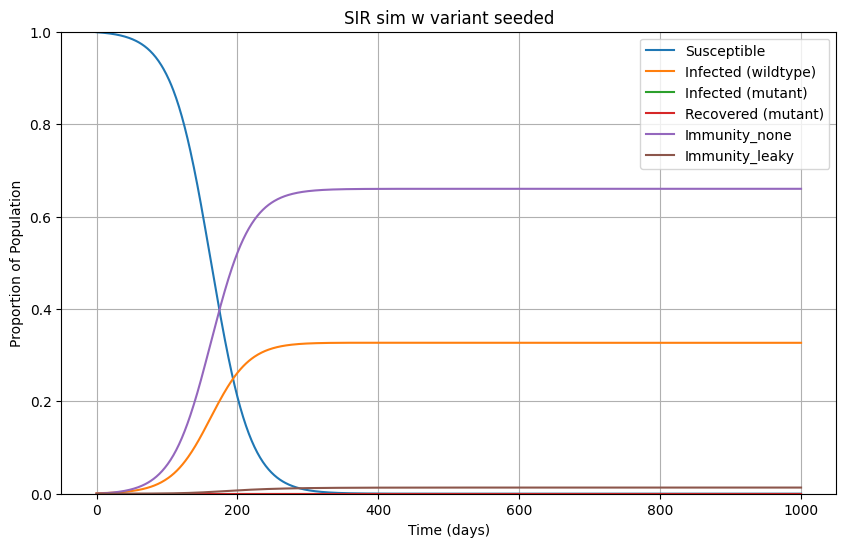

In [49]:
#solve and plot
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)